<a href="https://colab.research.google.com/github/shashankcuber/mRNA_Vacc_Stabilization/blob/main/mRNA_vaccine_stabilizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount dataset and rna tools from Drive

In [1]:
from google.colab import drive
#make sure you give the necessary authorization for colab to access your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
open_vaccine_test_data_path = '/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/test_data.csv'

# Installing RNA tools

In [ ]:
!cd drive/MyDrive/Bio_informatics_Project/; sh install.sh -Uq

Fix these changes if you download the contrafold source code directly from http://contra.stanford.edu/contrafold/download.html


1.   LBFGS.ipp :  At line 110 write this->DoLineSearch
2.   Utilities.cpp:  Add #include"climits" for ULONG used in this file



# Setting up the arnie conf file and environment variable

In [5]:
import os
os.environ["DATAPATH"] = "/content/RNAstructure/data_tables"
os.environ["ARNIEFILE"] = "/content/arnie.conf"
!cd drive/MyDrive/Bio_informatics_Project/; sh make_arnie_conf.sh

/content
/content/arnie.conf
/content/RNAstructure/data_tables
TMP: /content/tmp
rnastructure: /content/RNAstructure/exe
contrafold_2: /content/contrafold-se/src
vienna_2: /usr/bin


# Importing Libraries For Test Data

In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
from arnie.bpps import bpps
import arnie.utils as utils
from arnie.mea.mea import MEA

# Test data replication using rna tools

In [7]:
class PrepareTestDataset:
  def __init__(self, rna_tool, path):
    self.package = rna_tool
    self.path = path
    self.df = pd.read_csv(path)


  def _predict_structure(self, id, rna_sequence):
    base_pairing_mat = bpps(rna_sequence, package = self.package)
    secondary_struct = MEA(base_pairing_mat)
    return id, rna_sequence, secondary_struct.structure, self.package
  
  def make_dataset(self):
    temp_df = self.df[['id','sequence']]
    
    dataset = []

    for j,(id,seq) in enumerate(tqdm(temp_df[['id', 'sequence']].values)):
      data = self._predict_structure(id, seq)
      dataset.append(data)

    df = pd.DataFrame(dataset, columns = ['id', 'sequence', 'structure','package'])
    df['seq_length'] = df['id'].map(self.df.drop_duplicates().set_index('id')['seq_length'])
    df['seq_scored'] = df['id'].map(self.df.drop_duplicates().set_index('id')['seq_scored'])
    return df

In [8]:
#vienna_2
vienna = PrepareTestDataset('vienna_2', open_vaccine_test_data_path)
vienna_df = vienna.make_dataset()
vienna_df.head()

100%|██████████| 600/600 [04:58<00:00,  2.01it/s]


,id,sequence,structure,package,seq_length,seq_scored
0,id_3b7827fb0,GGAAACGUCUGUAGCUGAGUGCUACAGACGAAUAGGUAGACAGCUG...,.....((((((((((.....))))))))))....(((((((((((....,vienna_2,130,91
1,id_f5212dd4e,GGAAAGUGCUACGCUGUACCGUGAGGUACAGCCGACGGUACGUCGG...,.....(((((((.(((((((....)))))))((((((...))))))...,vienna_2,130,91
2,id_0d6a71f64,GGAAAGCGAAUCGACGAGAAGUCGUAGUUCGCAGAGCGGCGUACCC...,.....((((((((((.....))))..))))))...((((((((......,vienna_2,130,91
3,id_6e072995a,GGAAACAAGCACACACUCUGCAGGCACAAAGGUGUAGUAGUUGUAU...,........((((((((((((((((((((..((((((((.(((((((...,vienna_2,130,91
4,id_5ccbcb6ff,GGAAAGUCUAGACGAACUAACUAGGACAUCCCUAGGUGAAGUACCA...,.....((((..(((......(((((.....)))))((((.((.......,vienna_2,130,91


In [ ]:
#contrafold_2
contrafold = PrepareTestDataset('contrafold_2', open_vaccine_test_data_path)
contrafold_df = contrafold.make_dataset()
contrafold_df.head()

In [ ]:
#rnastructure
rnastructure = PrepareTestDataset('rnastructure', open_vaccine_test_data_path)
rnastructure_df = rnastructure.make_dataset()
rnastructure_df.head()

# Importing Libraries for Model Pipeline

In [45]:
"""
Importing the necessary libraries
"""
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.modules.loss import MSELoss
torch.backends.cudnn.deterministic = True

import random

# To ensure the random function generates the same random values on different runs
random.seed(hash("setting random seeds") % 2023)
np.random.seed(hash("improves reproducibility") % 2023)
torch.manual_seed(hash("by removing stochasticity") % 2023)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2023)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
token_int_dict = {
        '(' : 0,
        ')' : 1,
        '.' : 2,
        'A' : 3,
        'G' : 4,
        'C' : 5,
        'U' : 6,
    }
WB_API_KEY = "38a7ef7ce5199afb39bb750165178c3197b4a56f"
config = {
    
}

In [15]:
"""
Insatalling Weights and Biases wandb to track the Model evaluation
and login to wandb
"""
!pip install wandb -Uq

import wandb
wandb.login(key = WB_API_KEY) 

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# EDA Train Data

In [16]:
"""
LOADING THE TRAIN DATA
"""
open_vaccine_train_data_path = '/content/drive/MyDrive/Bio_informatics_Project/open_vac_data/train.json'
train_df = pd.read_json(open_vaccine_train_data_path, lines=True)
train_df = train_df.drop(columns=['index'])
train_df.head(3)

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."


In [17]:
class DataPreprocessing:
  def __init__(self, data, device, token_int_dict, feature_columns = ["sequence", "structure"], 
               train_data = True, labels = None):
    self.df = data
    self.feature_columns = feature_columns
    self.labels = labels
    self.token_int_dict = token_int_dict
    self.device = device
    self.is_train = train_data

  def num_missing_val(self):
    return self.df.isnull().values.sum()

  def sn_filtering(self):
    self.df = self.df[self.df.SN_filter == 1]

  def tokenize_sequence(self,sequence):
    tokenized_sequence = []
    for char in sequence:
      tokenized_sequence.append(self.token_int_dict[char])
    return tokenized_sequence

  def convert_df_to_array(self, df):
    return np.transpose(np.array(df.values.tolist()), (0,2,1))

  def process_data(self):
    #check if any missing values
    if self.num_missing_val() > 0 and self.is_train:
      self.sn_filtering()
      print(f"Number of missing values in the dataset are:{self.num_missing_val()}")
    elif self.is_train:
      self.sn_filtering()
      print("No Missing Values")
    
    feature_df = self.df[self.feature_columns].applymap(lambda sequence: self.tokenize_sequence(sequence))
    feature_tensor =  torch.tensor(self.convert_df_to_array(feature_df)).to(self.device)

    if self.is_train:
      label_tensor = torch.tensor(self.convert_df_to_array(self.df[self.labels])).float().to(device)
      return feature_tensor, label_tensor
  
    return feature_tensor

In [18]:
labels = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']
train_process = DataPreprocessing(train_df, device, token_int_dict,  labels = labels)
x_train, y_train = train_process.process_data()
print(x_train.shape)
print(y_train.shape)

No Missing Values
torch.Size([1589, 107, 2])
torch.Size([1589, 68, 5])


In [20]:
vienna_df_public = vienna_df.query("seq_length == 107").copy()
vienna_df_private = vienna_df.query("seq_length == 130").copy()
test_process_public = DataPreprocessing(vienna_df_public, device, token_int_dict, train_data = False)
vienna_public_tensor = test_process_public.process_data()
test_process_private = DataPreprocessing(vienna_df_private, device, token_int_dict, train_data = False)
vienna_private_tensor = test_process_private.process_data()
print(vienna_public_tensor.shape)
print(vienna_private_tensor.shape)

torch.Size([300, 107, 2])
torch.Size([300, 130, 2])


# MCRMSE LOSS
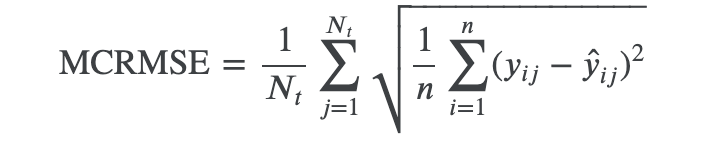

In [47]:
class MeanColumnwiseRMSE(nn.Module):
  def __init__(self, N_t):
    self.loss = nn.MSELoss()
    self.nt = N_t
  
  def forward(self, predicted , actual):
    total_loss = 0

    for j in range(self.nt):
        total_loss += torch.sqrt(self.loss(predicted[:, :, j], actual[:, :, j]))

    total_loss /= self.nt

# Configuration of bi-GRU model and Hyperparams

In [41]:
model_config = dict(
    embedding_dim = 200,
    gru_input_size = 200 * 3,
    gru_hidden_size = 128,
    gru_num_layers = 3,
    gru_dropout_rate = 0.5,
)

training_config = dict(
    k_fold = 5,
    epochs = 100,
    batch_size = 64,
    learning_rate = 0.1,
)

# bi-GRU Model

In [44]:
class bi_GRU(nn.Module):
  def __init__(self, config, public_data = False, private_data = False):
    super(bi_GRU, self).__init__()
    
    if(public_data):
      self.prediction_len = 68
      self.squence_len = 107
    elif private_data:
      self.prediction_len = 91
      self.squence_len = 130

    self.token_int_len = len(token_int_dict)
    self.embedding_layer = nn.Embedding(num_embeddings = self.token_int_len, embedding_dim = config.embedding_dim)
    self.bi_gru = nn.GRU(
        input_size = config.gru_input_size,
        hidden_size = config.gru_hidden_size,
        num_layers = config.gru_num_layers, # hidden_layers
        batch_first = True,
        dropout = config.gru_dropout_rate,
        bidirectional = True)
    self.l1 = nn.Linear(config.hidden_size * 2, len(labels))
  
  def reshape_embedding(self, embedding):
      x , y , z = embedding.shape[1] , embedding.shape[2], embedding.shape[3]
      return torch.reshape(embedding, (-1, x, y * z))
      
  def forward(self, sequence):
    embedding = self.embedding_layer(sequence)
    embed_reshape = self.reshape_embedding(embedding)
    output,h_n = self.bi_gru(embed_reshape)
    slice_output = output[:, : self.prediction_len, :]
    final_output = self.l1(slice_output)
    return final_output